# HATE RETORIC DETECTION AND CLASSIFICATION
Objective is to create a deep learning model to identify hate retoric and identifiy target group. Labeled data is available.\
 *Note that current proejct is not aiming at defining optimal model. Focus is rather on roughly exploring basic concepts using very limited hardvare resources.\
 Tranfer learning is outside of the project scope*

# Imports and helper functions

In [1]:
# data exploration and preparation
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# training and evaluation
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
def set_random_seed(random_seed):
  """Sets random seed for reproducibility"""
  tf.random.set_seed(random_seed)
  np.random.seed(random_seed)
  tf.keras.utils.set_random_seed(random_seed)

def count_words_in_df(text):
    """Calculates total number of words and number of uniqe words in a dataframe column"""
    rows = text.apply(lambda row: row.split(' ')) # create a list of words for each row
    word_tot = [word for row in rows for word in row] # concatinate all words from whole dataframe into one list
    word_uniqe = set(word_tot)
    return len(word_tot), len(word_uniqe)

def clean_text(text, lemmatizer = None):
    '''Removes leading and trailing whitespaces and puncutation, normalizes all characters to lower case, removes some stop words and lemmatizes text (nouns and verbs)'''
    if lemmatizer == None:
        lemmatizer = WordNetLemmatizer()

    stopwords_to_keep = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't",
    }

    text = text.strip() # remove leading and trailing white spaces
    text = "".join([character.lower() for character in text[0:-1]]) # remove end of sentance '.' and lower case
    words = text.split(' ')
    words_cleaned = [lemmatizer.lemmatize(word) for word in words if word not in (set(stopwords.words('english')) - stopwords_to_keep)] # list non-stopwords and lemmatize nouns
    words_cleaned = [lemmatizer.lemmatize(word, pos='v') for word in words_cleaned] # lemmatize verbs
    text_cleaned = (' ').join(words_cleaned) # join back into a cleaned text
    text_cleaned = "".join([character for character in text_cleaned if character not in string.punctuation]) # remove remaining punctuation
    return text_cleaned

def plot_label_distribution(y_array, y_train, y_val, y_test, labels_dict):
  """Plots label distribution in all data, train, val and test datasets."""
  titles = ['All data', 'Train data', 'Validation data', 'Test data']
  datasets = [y_array, y_train, y_val, y_test]
  labels_list = list(labels_dict.keys())

  fig = plt.figure(figsize=(16, 6))
  for i in range(4):
    plt.subplot(1, 4, i+1)
    _, counts = np.unique((np.argmax(datasets[i], axis=1)), return_counts=True)
    plt.bar(labels_list, counts)
    plt.title(titles[i])
    plt.xticks(rotation='vertical')

  fig.suptitle('Number of labels as function of class')
  fig.tight_layout()
  plt.subplots_adjust(top=0.85)
  plt.show()

def plot_training_history(train_loss, train_accuracy, train_recall, val_loss, val_accuracy, val_recall):
  """Plots metrics during training for train and validation data."""
  titles = ['Loss', 'Accuracy', 'Recall']
  train_history = [train_loss, train_accuracy, train_recall]
  val_history = [val_loss, val_accuracy, val_recall]

  fig = plt.figure(figsize=(12, 3))
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(train_history[i], label='train')
    plt.plot(val_history[i], label='val')
    plt.title(titles[i])
    plt.ylabel(titles[i])
    plt.xlabel('Epoch')

  fig.tight_layout()
  plt.legend()
  plt.show()

def train_validate_and_plot(model, X_train, y_train, X_val, y_val, epochs, batch_size = 32, early_stopping=False):
  """Fits train data to model and evaluates with validation data. Visulaizes training history. Returns values from last epoch or from best if early stopping is True"""
  if early_stopping:
    patience = 10
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])
  else:
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, verbose=0)

  train_loss, train_accuracy, train_recall, val_loss, val_accuracy, val_recall = history.history.values()
  plot_training_history(train_loss, train_accuracy, train_recall, val_loss, val_accuracy, val_recall)

  if early_stopping:
    patience_values = val_loss[-patience:]
    best_epoch = len(val_loss) - patience + patience_values.index(max(patience_values)) # calculates position in val_loss list for best val_loss value
    print(f'Best epoch: {best_epoch+1}')
    print(f"Loss (best epoch):     training: {train_loss[best_epoch]:.4f}     validation: {val_loss[best_epoch]:.4f}")
    print(f"Accuracy (best epoch): training: {train_accuracy[best_epoch]:.4f}     validation: {val_accuracy[best_epoch]:.4f}")
    print(f"Recall (best epoch):   training: {train_recall[best_epoch]:.4f}     validation: {val_recall[best_epoch]:.4f}")
    return train_loss[best_epoch], val_loss[best_epoch], train_accuracy[best_epoch], val_accuracy[best_epoch], train_recall[best_epoch], val_recall[best_epoch]
  else:
    print(f"Loss (last epoch):     training: {train_loss[-1]:.4f}     validation: {val_loss[-1]:.4f}")
    print(f"Accuracy (last epoch): training: {train_accuracy[-1]:.4f}     validation: {val_accuracy[-1]:.4f}")
    print(f"Recall (last epoch):   training: {train_recall[-1]:.4f}     validation: {val_recall[-1]:.4f}")
    return train_loss[-1], val_loss[-1], train_accuracy[-1], val_accuracy[-1], train_recall[-1], val_recall[-1]

def test_model(model, X_test, y_test):
  """Displays metrics for test data"""
  test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test, verbose=0)
  print(f'Test loss: {test_loss:.4f}')
  print(f'Test accuracy: {test_accuracy:.4f}')
  print(f'Test recall: {test_recall:.4f}')

def display_test_metrics(model, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=True, display_confusion_matrix=True, display_missclassified=True):
  """Calculate number of false negatives and optionally display classification report, confusion matrix and missclassified cleaned sentences"""
  y_pred = model.predict(X_test_tokenized, verbose=0)
  labels_list = list(labels_dict.keys())
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_test_classes = np.argmax(y_test, axis=1)

  # number of false negatives
  false_negatives = sum((np.argmax(y_pred, axis=1) == 0) & (np.argmax(y_test, axis=1) != 0))
  print(f'Number of false negatives: {false_negatives} ({(100 * false_negatives/len(y_test)):.2f}%)\n')

  # classification report
  if display_classification_report:
    print('\nClassification report:')
    print(classification_report(y_true=y_test_classes, y_pred=y_pred_classes, target_names=labels_list))
    print('='*100, end='\n')

  # confusion matrix
  if display_confusion_matrix:
    print('Confusion matrix:')
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

  # miss classified test cases
  if display_missclassified:
    print('\nMissclassified test samples:')
    idx_miss = np.where(y_pred_classes != y_test_classes)[0].tolist()
    X_miss_cleaned, y_test_miss, y_pred_miss = X_test[idx_miss], y_test_classes[idx_miss], y_pred_classes[idx_miss]
    df = pd.DataFrame({'test_case_cleaned': X_miss_cleaned, 'true_label': [labels_list[i] for i in y_test_miss], 'predicted_label': [labels_list[i] for i in y_pred_miss]})
    df.index = idx_miss
    display(df)
    print(f'\n{len(df)} samples were missclassified in test data')

In [3]:
set_random_seed(42)

# 1. Data exploration

In [4]:
# # colab specific
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_hate_retoric/data/hate-text.csv', index_col='case_id')

Mounted at /content/drive


In [5]:
df = pd.read_csv('data/hate-text.csv', index_col='case_id')
df.head()

,test_case,label_gold,target_ident
case_id,,,
1,I hate women.,hateful,women
2,I hate trans people.,hateful,trans people
3,I hate gay people.,hateful,gay people
4,I hate black people.,hateful,black people
5,I hate disabled people.,hateful,disabled people


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3901 entries, 1 to 3901
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   test_case     3901 non-null   object
 1   label_gold    3901 non-null   object
 2   target_ident  3606 non-null   object
dtypes: object(3)
memory usage: 121.9+ KB


In [7]:
# find unique values in column label_gold
df.label_gold.value_counts()

hateful        2659
non-hateful    1242
Name: label_gold, dtype: int64

In [8]:
# calculate number of rows with missing values for target_ident
len(df[df.target_ident.isna()])

295

In [9]:
# find unique values in column target_ident
df.target_ident.value_counts()

gay people         577
women              535
disabled people    510
Muslims            510
black people       504
trans people       485
immigrants         485
Name: target_ident, dtype: int64

In [10]:
# define which labels are associated with the missing target_ident values
df[df.target_ident.isna()].label_gold.value_counts()

non-hateful    295
Name: label_gold, dtype: int64

In [11]:
# calcualate total number of words and unique number of words in dataframe
words_tot_count, words_unique_count = count_words_in_df(df.test_case)
print(f'Total words in dataframe is {words_tot_count}, where {words_unique_count} are unique')

Total words in dataframe is 38068, where 1869 are unique


In [12]:
# calculate the longest input
text_length = df.test_case.apply(lambda row: len(row.split(' ')))
max_length = text_length.max()
longest_text = text_length.argmax()
print(f'Longest sentence is "{df.test_case[longest_text+1]}". It contains {max_length} words')

Longest sentence is "If I want to call myself a fag I will, and you will not say a word on it. ". It contains 20 words


Dataset prior to any manipulation consists of 3091 rows and 3 columns:
*   'test_case' containig text to be analyzed, longest input is 20 words including end white space, total words in dataframe is 38068, where 1869 are unique
*   'label_gold': no missing values, 2 classes: 'hateful', 'non-hateful', balance 32%-68% which is considered good enough for current task
*   'target identity' has 7 uniqe classes, missing values on 295 rows, all missing rows belong to label 'non-hateful'

# 2. Data preparation

## Features

The following is done for input text:
* removed leading and trailing white spaces
* removed punctuation
* lower case
* removed stopwords not associated with negation
* lemmatized verbs and nouns
* remove rows with 0 or 1 word after cleaning

In [6]:
# clean input text in test_case series
df['test_case_cleaned'] = df.test_case.apply(lambda row_text: clean_text(row_text))

In [7]:
# remove rows with 1 or 0 words
df['word_count'] = df['test_case_cleaned'].str.split().str.len()
df = df[df['word_count'] > 1].drop(columns=['word_count'])
print(f'Final data contains {len(df)} samples. {3901-len(df)} contained 0 or 1 words after cleaning and were removed.')

Final data contains 3847 samples. 54 contained 0 or 1 words after cleaning and were removed.


In [8]:
# calculate the longest input after data cleaning
text_length = df.test_case_cleaned.apply(lambda row: len(row.split(' ')))
max_length = text_length.max()
longest_text = text_length.argmax()
print(f'Longest sentence is "{df.test_case_cleaned[longest_text+1]}". It contains {max_length} words')

Longest sentence is "make say stuff like these black people disgust much". It contains 11 words


In [9]:
# calcualate total number of words and unique number of words in dataset after data cleaning
words_tot_count, words_unique_count = count_words_in_df(df.test_case_cleaned)
print(f'Total words in dataframe is {words_tot_count}, where {words_unique_count} are unique')

Total words in dataframe is 18323, where 1166 are unique


## Targets

Task is to classify text into non-hateful or hateful. If hateful target group should be defined. No target is needed for non-hateful.\
The following is done to labels:
* 8 labels are created: non-hateful and 7 hateful for each of the targets: 'women', 'trans people', 'gay people', 'black people','disabled people', 'Muslims', 'immigrants'
* one-hot encoding

In [10]:
# create new label series containg "non-hateful" or "hateful against 'target_identity'"
df['label'] = df.apply(lambda row: f'hateful against {row["target_ident"]}' if row['label_gold'] == 'hateful' else 'non-hateful', axis=1)
df.head()

,test_case,label_gold,target_ident,test_case_cleaned,label
case_id,,,,,
1,I hate women.,hateful,women,hate woman,hateful against women
2,I hate trans people.,hateful,trans people,hate trans people,hateful against trans people
3,I hate gay people.,hateful,gay people,hate gay people,hateful against gay people
4,I hate black people.,hateful,black people,hate black people,hateful against black people
5,I hate disabled people.,hateful,disabled people,hate disable people,hateful against disabled people


In [11]:
# one-hot encode labels
labels_dict = {
    'non-hateful': 0,
    'hateful against women': 1,
    'hateful against trans people': 2,
    'hateful against gay people': 3,
    'hateful against black people': 4,
    'hateful against disabled people': 5,
    'hateful against Muslims': 6,
    'hateful against immigrants': 7
}

df.label = df.label.replace(labels_dict) # str -> int (key -> value)
y_array = df.label.to_numpy() # pd.Series -> array
y_array = to_categorical(y_array, len(labels_dict)) # one-hot encoding
y_array.shape # shape should be (rows, categories)

(3847, 8)

Prepared data consists of 3847 text samples with 8 labels. Longest text input is 11 words.

## Train|val|test - split (60|20|20)

In [12]:
# trasnform text input series into a numpy array.
X_array_cleaned = df.test_case_cleaned.to_numpy()

In [13]:
# split X_array and y_array into train/val/test
X_trainval, X_test, y_trainval, y_test =train_test_split(X_array_cleaned, y_array, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val =train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2307,), (770,), (770,), (2307, 8), (770, 8), (770, 8))

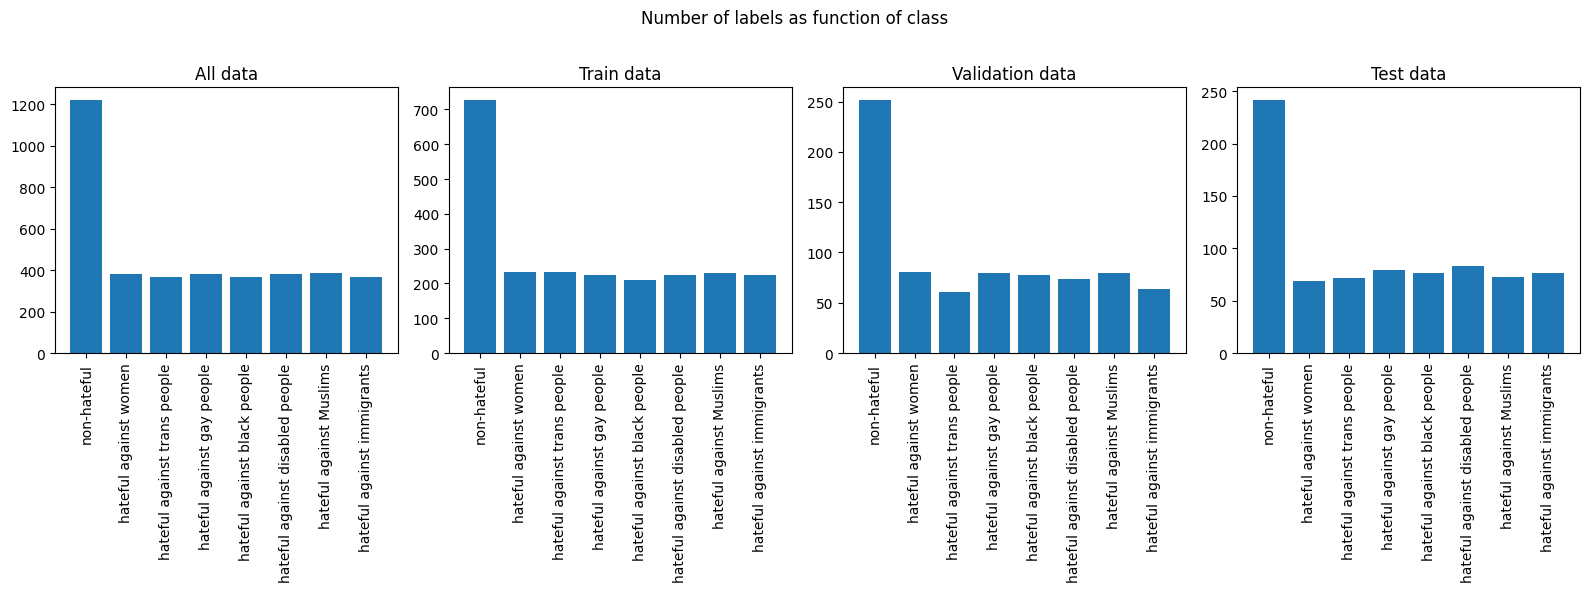

In [21]:
plot_label_distribution(y_array, y_train, y_val, y_test, labels_dict)

The 'non-hateful' class has approximately 3 times more samples in the datsets. Remaining classes are evenly distributed. In addition, distribution between train, val and test datasets is comparable.

## Tokenize and pad text

In [14]:
# create a list of unique words appearing at lest min_words_frequency times in X_train
min_word_frequency = 2

frequent_words = pd.Series(X_train).str.split().explode().value_counts()
frequent_words = frequent_words[frequent_words >= min_word_frequency]
frequent_words = frequent_words.keys().to_list()
print(f'X_train contains {len(frequent_words)} unique words which appear at least {min_word_frequency} times')

X_train contains 626 unique words which appear at least 2 times


In [15]:
# prepare vectorizer
vocab_size = 650    # dataset contains 1166 unique words, but only a bit over 600 appear more than once in X_train
max_length = 12    # maximum sentence lenth is 11 words after data cleaning

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length)

In [16]:
# build vocabulary based on freqent words in X_train
vectorize_layer.adapt(frequent_words)

In [17]:
# tokenize X_train, X_val and X_test (arrays -> tensors with padding up to max_length)
X_train_tokenized = vectorize_layer(X_train)
X_val_tokenized = vectorize_layer(X_val)
X_test_tokenized = vectorize_layer(X_test)

X_train_tokenized.shape, X_val_tokenized.shape, X_test_tokenized.shape

(TensorShape([2307, 12]), TensorShape([770, 12]), TensorShape([770, 12]))

# 3. Build and evaluate basic model

Sentences are relatively short thus GRU is chosen for model.

In [43]:
set_random_seed(42)

In [44]:
embedding_dim = 32

# define model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_1.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [45]:
model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 12, 32)            20800     
                                                                 
 gru_37 (GRU)                (None, 128)               62208     
                                                                 
 dense_12 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 84040 (328.28 KB)
Trainable params: 84040 (328.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


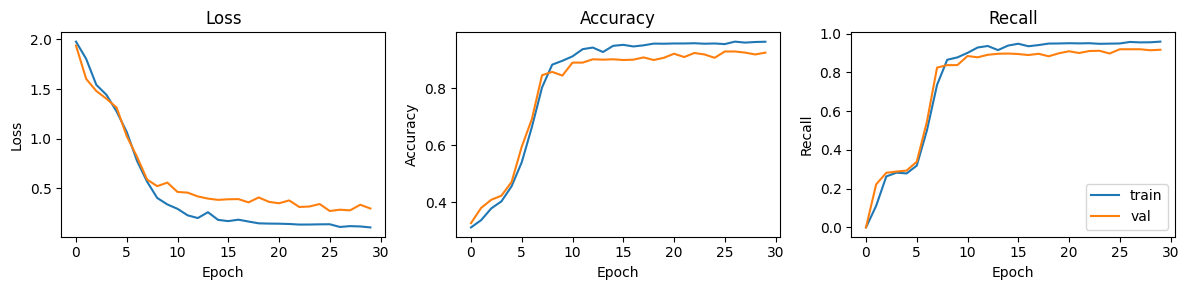

Loss (last epoch):     training: 0.1084     validation: 0.2988
Accuracy (last epoch): training: 0.9627     validation: 0.9247
Recall (last epoch):   training: 0.9588     validation: 0.9169


(0.1083904579281807,
 0.29880207777023315,
 0.96272212266922,
 0.9246753454208374,
 0.9588209986686707,
 0.916883111000061)

In [46]:
# visualize training behavior and results
train_validate_and_plot(model=model_1, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
# evaluate model on test data
test_model(model_1, X_test_tokenized, y_test)

Test loss: 0.2277
Test accuracy: 0.9338
Test recall: 0.9247


Number of false negatives: 17 (2.21%)


Classification report:
                                 precision    recall  f1-score   support

                    non-hateful       0.93      0.95      0.94       242
          hateful against women       0.89      0.90      0.89        69
   hateful against trans people       0.92      0.93      0.92        72
     hateful against gay people       0.97      0.90      0.93        79
   hateful against black people       0.94      0.97      0.95        76
hateful against disabled people       0.89      0.94      0.91        83
        hateful against Muslims       0.97      0.92      0.94        73
     hateful against immigrants       0.99      0.92      0.95        76

                       accuracy                           0.93       770
                      macro avg       0.94      0.93      0.93       770
                   weighted avg       0.93      0.93      0.93       770

Confusion matrix:


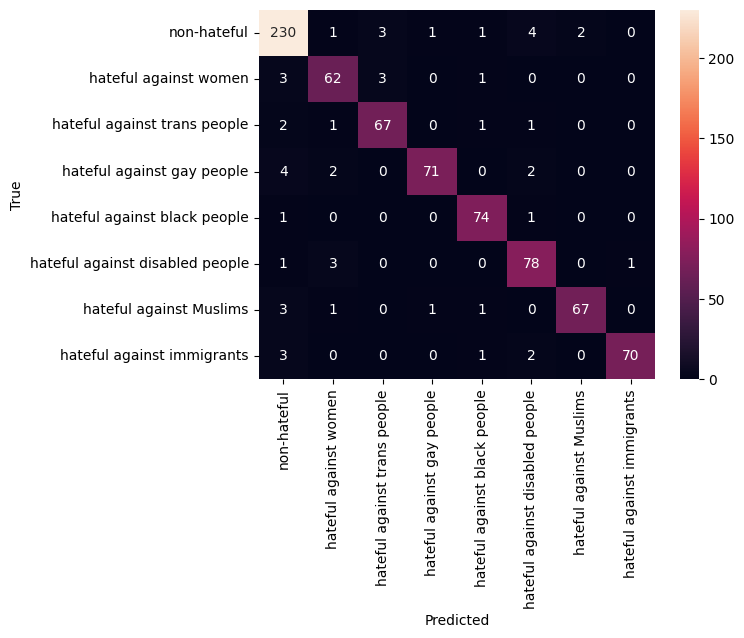


Missclassified test samples:


,test_case_cleaned,true_label,predicted_label
36,nothing m0ng,hateful against disabled people,non-hateful
38,typical tr4nny behaviour,hateful against trans people,non-hateful
69,love gay people,non-hateful,hateful against disabled people
70,go make disable people smile,non-hateful,hateful against disabled people
72,people really not realise woman disgust,hateful against women,hateful against trans people
80,rid rollercoaster make sick,non-hateful,hateful against Muslims
83,woman no right alive,hateful against women,hateful against trans people
99,many h e l e country,hateful against trans people,hateful against black people
126,nothing j1hadi,hateful against Muslims,non-hateful
155,cut transthroats,hateful against trans people,non-hateful


51 samples were missclassified in test data


In [ ]:
# display metrics on test data
display_test_metrics(model_1, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=True, display_confusion_matrix=True, display_missclassified=True)

Basic model has fairly good perforace with some overfitting since resulting validation accuracy and recall are lower for validation data compared to train data. In Cclassification report it is indicated by somewhat lower scores that 'hateful against woman' is a bit more difficult to predict. Remaining categories are comparable. In the confusion matrix it can be seen that the miss-classified sentences are fairly evenly distributed. There are some false negatives predicted from test data. Minimizing false negatives is especially interesting considering the nature of the task, which is to be able to quickly discover hateful messages.

# 4. Explore model performace - manual exploration

The model is to be made more complex to show capability to learn and control overfitting with regularization techniques.\
Complexity can be added to increase train metrics via for example:
* larger embeddings dimension
* more complex classifier
* additional GRU layers
* deeper GRU layers


Regularization strategies to imporve generalization capability of the model can be for example:
* Dropout layers
* weight decay on optimizer
* kernel regularization of GRU layers
* early stopping

In the following performance at 30 epochs is compared for different models

## Larger embeddings dimension

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_2.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_4 (GRU)                 (None, 128)               246528    
                                                                 
 dense_6 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 580360 (2.21 MB)
Trainable params: 580360 (2.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


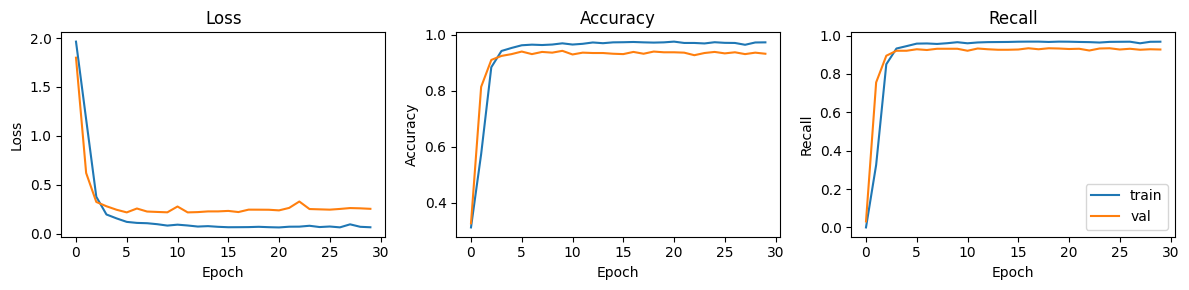

Loss (last epoch):     training: 0.0639     validation: 0.2527
Accuracy (last epoch): training: 0.9731     validation: 0.9325
Recall (last epoch):   training: 0.9679     validation: 0.9273


In [ ]:
train_validate_and_plot(model=model_2, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_2, X_test_tokenized, y_test)

Test loss: 0.2409
Test accuracy: 0.9377
Test recall: 0.9338


In [ ]:
display_test_metrics(model_2, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 4 (0.52%)



Results higher embedding dimenssion:

* improved metrics for training and validation
* lower number of false negatives
* faster convergence.

## More complex classifier

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_3.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_3 (GRU)                 (None, 128)               246528    
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 604616 (2.31 MB)
Trainable params: 604616 (2.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


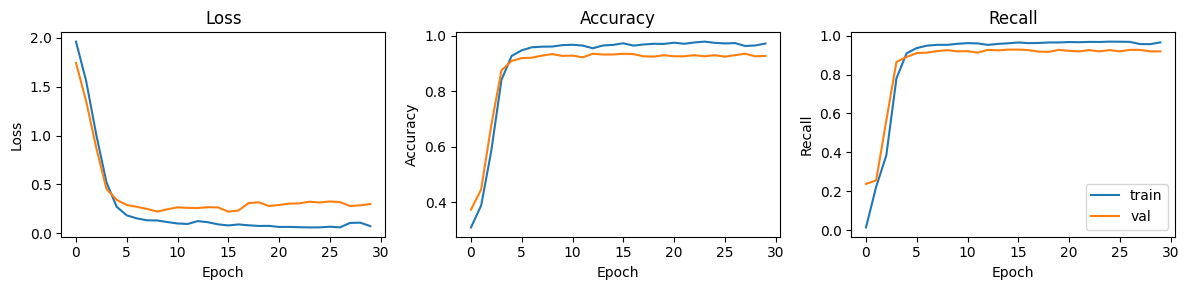

Loss (last epoch):     training: 0.0742     validation: 0.3003
Accuracy (last epoch): training: 0.9718     validation: 0.9273
Recall (last epoch):   training: 0.9658     validation: 0.9195


In [ ]:
train_validate_and_plot(model=model_3, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_3, X_test_tokenized, y_test)

Test loss: 0.2476
Test accuracy: 0.9364
Test recall: 0.9351


In [ ]:
display_test_metrics(model_3, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 16 (2.08%)



Results more complex classifier:
* no improvment to metrics
* increased number of false negatives

## Additional GRU layers - 2

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_4.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_14 (GRU)                (None, 12, 128)           246528    
                                                                 
 gru_15 (GRU)                (None, 64)                37248     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
Total params: 617096 (2.35 MB)
Trainable params: 617096 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


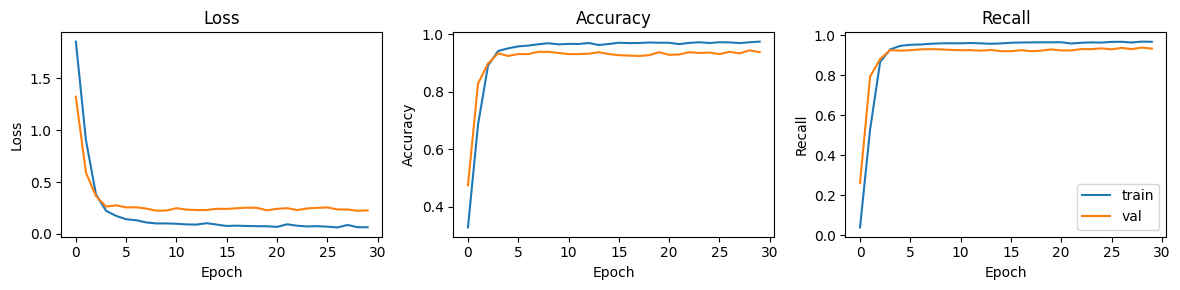

Loss (last epoch):     training: 0.0646     validation: 0.2271
Accuracy (last epoch): training: 0.9744     validation: 0.9377
Recall (last epoch):   training: 0.9679     validation: 0.9338


In [ ]:
train_validate_and_plot(model=model_4, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_4, X_test_tokenized, y_test)

Test loss: 0.2374
Test accuracy: 0.9416
Test recall: 0.9377


In [ ]:
display_test_metrics(model_4, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 5 (0.65%)



Results additional GRU layers:
* possibly small improved to metrics for training and validation
* possibly higher number of false negatives

## Deeper GRU layers

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(256, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_5.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 512)           332800    
                                                                 
 gru (GRU)                   (None, 12, 256)           591360    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 1073416 (4.09 MB)
Trainable params: 1073416 (4.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


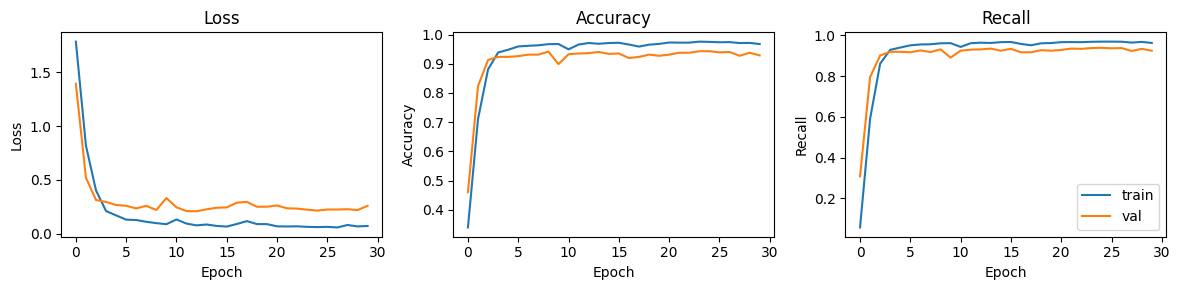

Loss (last epoch):     training: 0.0731     validation: 0.2601
Accuracy (last epoch): training: 0.9675     validation: 0.9286
Recall (last epoch):   training: 0.9627     validation: 0.9247


In [ ]:
train_validate_and_plot(model=model_5, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_5, X_test_tokenized, y_test)

Test loss: 0.2637
Test accuracy: 0.9286
Test recall: 0.9221


In [ ]:
display_test_metrics(model_5, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 7 (0.91%)



Results deeper GRU layers:
* slightly worse metrics from training and evaluation
* more false negatives

## Additional GRU layers - 3

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_6.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_2 (GRU)                 (None, 12, 128)           246528    
                                                                 
 gru_3 (GRU)                 (None, 12, 64)            37248     
                                                                 
 gru_4 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 626248 (2.39 MB)
Trainable params: 626248 (2.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


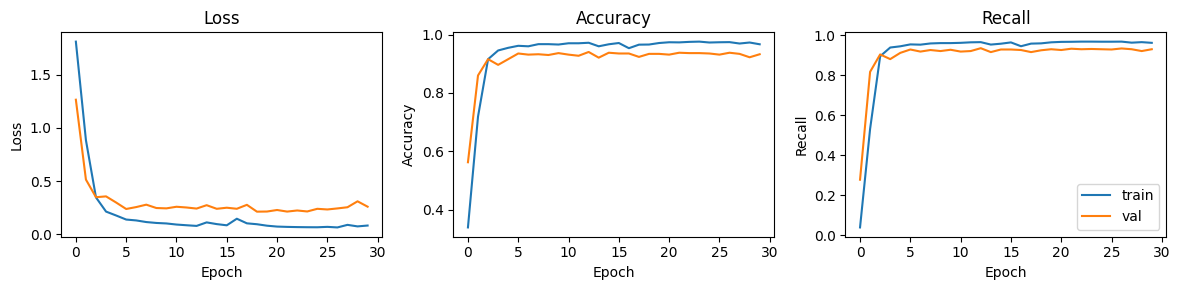

Loss (last epoch):     training: 0.0806     validation: 0.2582
Accuracy (last epoch): training: 0.9666     validation: 0.9325
Recall (last epoch):   training: 0.9619     validation: 0.9299


In [ ]:
train_validate_and_plot(model=model_6, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_6, X_test_tokenized, y_test)

Test loss: 0.2185
Test accuracy: 0.9351
Test recall: 0.9312


In [ ]:
display_test_metrics(model_6, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 12 (1.56%)



Results additional GRU layers:
* lower performance of metrics for training and validation
* higher number of false negatives

## Weight decay on Adam optimizer

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_7 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_7.compile(
  optimizer=tf.keras.optimizers.AdamW(weight_decay=0.01), # AdamW with weight_decay
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_7 (GRU)                 (None, 12, 128)           246528    
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 617096 (2.35 MB)
Trainable params: 617096 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


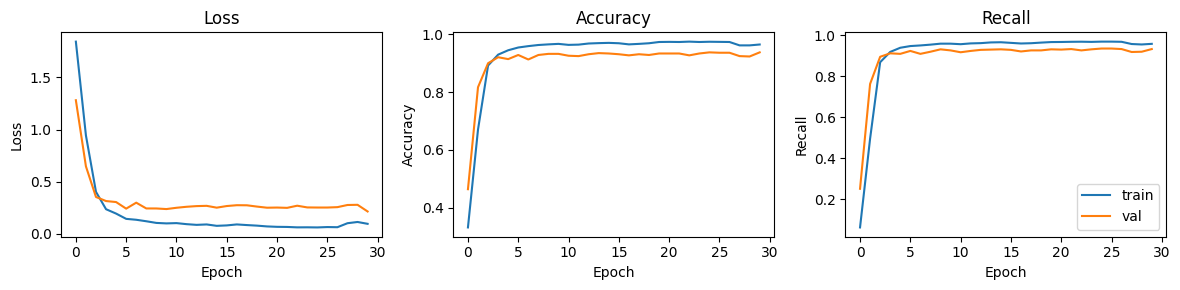

Loss (last epoch):     training: 0.0973     validation: 0.2156
Accuracy (last epoch): training: 0.9649     validation: 0.9377
Recall (last epoch):   training: 0.9580     validation: 0.9325


In [ ]:
train_validate_and_plot(model=model_7, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_7, X_test_tokenized, y_test)

Test loss: 0.1936
Test accuracy: 0.9429
Test recall: 0.9364


In [ ]:
display_test_metrics(model_7, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 8 (1.04%)



*AdamW is used instead of Adam to implement weight decay. According to several sources AdamW is a better choice compared to Adam for weight decay (example https://pub.aimind.so/keras-optimizers-explained-adam-optimizer-521638f6be0c)*\

Results with AdamW(weight_decay=0.004 and 0.01): approximately same results.

## Dropout

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_8 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_8.compile(
  optimizer=tf.keras.optimizers.AdamW(weight_decay=0.004), # AdamW with weight_decay
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_9 (GRU)                 (None, 12, 128)           246528    
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 gru_10 (GRU)                (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
Total params: 617096 (2.35 MB)
Trainable params: 61709

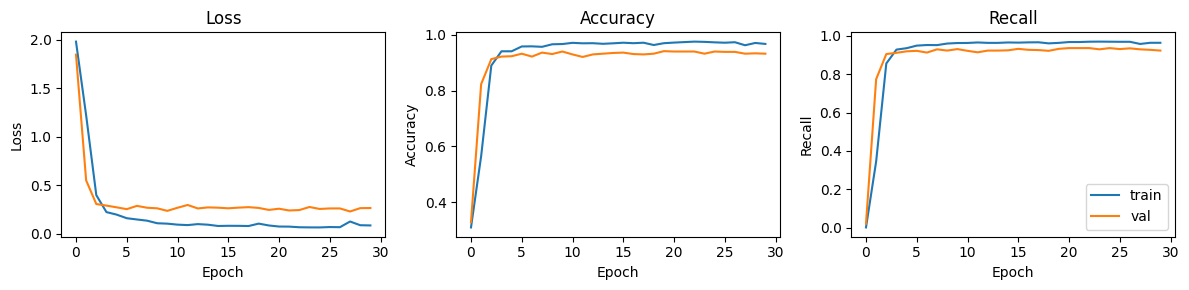

Loss (last epoch):     training: 0.0855     validation: 0.2651
Accuracy (last epoch): training: 0.9675     validation: 0.9325
Recall (last epoch):   training: 0.9640     validation: 0.9234


In [ ]:
train_validate_and_plot(model=model_8, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_8, X_test_tokenized, y_test)

Test loss: 0.2528
Test accuracy: 0.9338
Test recall: 0.9325


In [ ]:
display_test_metrics(model_8, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 9 (1.17%)



Results with Dropout: approximately unchanged results

## L2 regularization of GRU

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_9 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, kernel_regularizer='l2', return_sequences=True),
    tf.keras.layers.GRU(64, kernel_regularizer='l2'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_9.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_2 (GRU)                 (None, 12, 128)           246528    
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 617096 (2.35 MB)
Trainable params: 617096 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


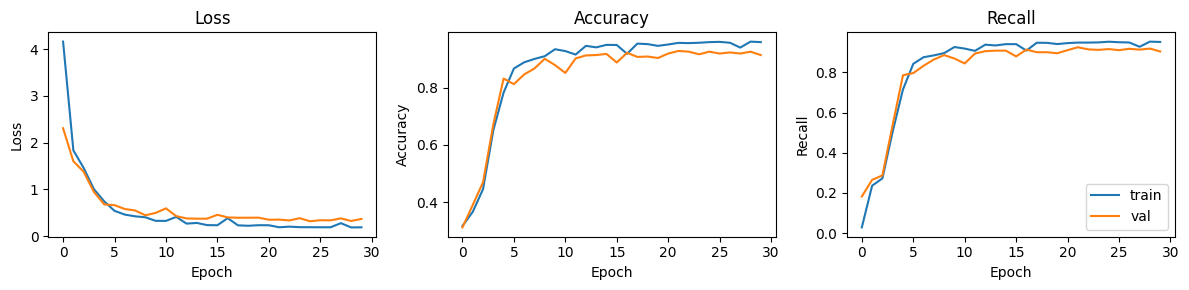

Loss (last epoch):     training: 0.1911     validation: 0.3700
Accuracy (last epoch): training: 0.9580     validation: 0.9130
Recall (last epoch):   training: 0.9510     validation: 0.9039


In [ ]:
train_validate_and_plot(model=model_9, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_9, X_test_tokenized, y_test)

Test loss: 0.3745
Test accuracy: 0.9078
Test recall: 0.9000


In [ ]:
display_test_metrics(model_9, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 4 (0.52%)



Results kernel_regularization of GRU layers:
* slightly worse metrics from training and evaluation
* fewer false negatives
* slower convergence
* improvement in overfitting

## Kullback_Leibler divergence loss

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_10 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_10.compile(
  optimizer='Adam',
  loss=tf.keras.losses.KLDivergence(), # loss = y_true * log(y_true / y_pred)
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 512)           332800    
                                                                 
 gru (GRU)                   (None, 12, 128)           246528    
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 617096 (2.35 MB)
Trainable params: 617096 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


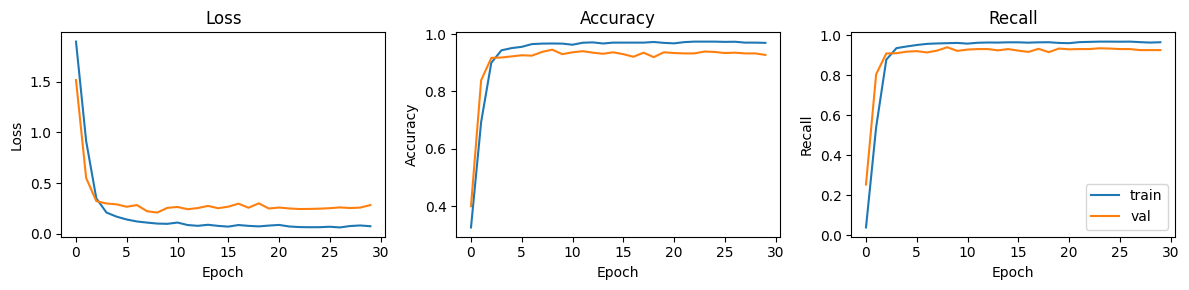

Loss (last epoch):     training: 0.0739     validation: 0.2826
Accuracy (last epoch): training: 0.9692     validation: 0.9273
Recall (last epoch):   training: 0.9653     validation: 0.9260


In [ ]:
train_validate_and_plot(model=model_10, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=30, batch_size=32)

In [ ]:
test_model(model_10, X_test_tokenized, y_test)

Test loss: 0.2314
Test accuracy: 0.9377
Test recall: 0.9338


In [ ]:
display_test_metrics(model_10, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 8 (1.04%)



Results with Kullback_Leibler divergence loss:
* slightly lower performance on training and validation
* more false negatives

## Additional GRU layers - 2 with early stopping

In [ ]:
set_random_seed(42)

In [ ]:
embedding_dim = 512

model_11 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_11.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
model_11.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 12, 512)           332800    
                                                                 
 gru_8 (GRU)                 (None, 12, 128)           246528    
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
Total params: 617096 (2.35 MB)
Trainable params: 617096 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


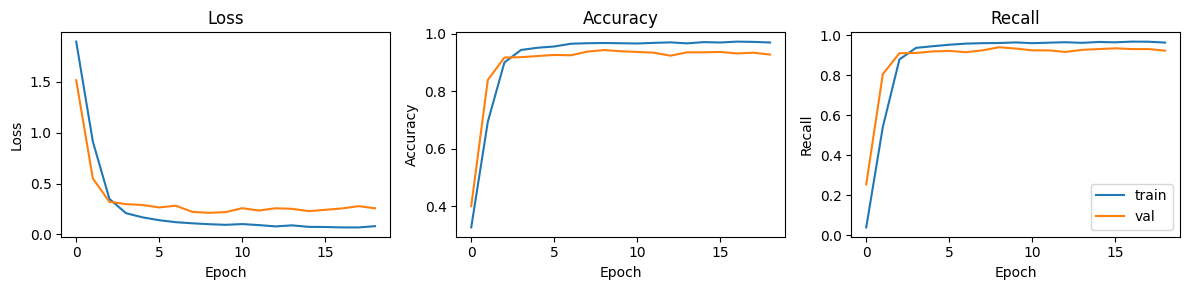

Loss (last epoch):     training: 0.0818     validation: 0.2574
Accuracy (last epoch): training: 0.9692     validation: 0.9273
Recall (last epoch):   training: 0.9623     validation: 0.9221


In [ ]:
train_validate_and_plot(model=model_11, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=100, batch_size=32, early_stopping=True)

In [ ]:
test_model(model_11, X_test_tokenized, y_test)

Test loss: 0.2157
Test accuracy: 0.9390
Test recall: 0.9325


In [ ]:
display_test_metrics(model_11, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=False, display_confusion_matrix=False, display_missclassified=False)

Number of false negatives: 15 (1.95%)



Results additional GRU layers:
* possibly small improved to metrics for training and validation
* possibly higher number of false negatives

## Conclusions from manual testing

Overall conclusion from manual testing is that the basic model performs well.
* Faster convergence and somewhat better performance is mostly improved with increased embeddings dimension. Some improvement can also be seen with additional GRU layer. Early stopping increases performance. Overfitting is improved with L2 regularization of GRU layers.
* A more complex classifier, vider GRU layers and Kullback_Leibler divergence loss decreased performace.
*  Dropout and weight decay of AdamW did not influence results.


# 5. Explore model performance - sytematic approach

## The model

Following model architecture is to be explored:
* Embedding (embedding dim)
* varying number of GRU layers with or without Dropout
  * GRU (128, kernel_regulizer = L2/None)
  * Dropout (0.5) - yes/None
* GRU (64, kernel_regulizer = L2/None)
* Dropout (0.5) - yes/None
* Dense (8, 'softmax', kernel_regulariser = L2/None)

In [41]:
# function building various models
def build_model(vocab_size=650, max_length=12, embedding_dim=512, num_GRU_layers=1, use_drop_out=False, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None):
  """Creates variations of model with various embedding dimensions, number of GRU layers, optional Dropout, optioinal kernel regulizers"""
  set_random_seed(42)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

  for _ in range(num_GRU_layers - 1):
    model.add(tf.keras.layers.GRU(128, return_sequences=True, kernel_regularizer=kernel_regularizer_GRU))
    if use_drop_out:
      model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.GRU(64, kernel_regularizer=kernel_regularizer_GRU))
  if use_drop_out:
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=kernel_regularizer_Dense))

  model.compile(
      optimizer=tf.keras.optimizers.AdamW(weight_decay=0.004),
      loss='categorical_crossentropy',
      metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
  )
  return model

## Hyperparameter tuning 1

Focus on dropout and kernel_regulizers of GRU and Dense layers

Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=2


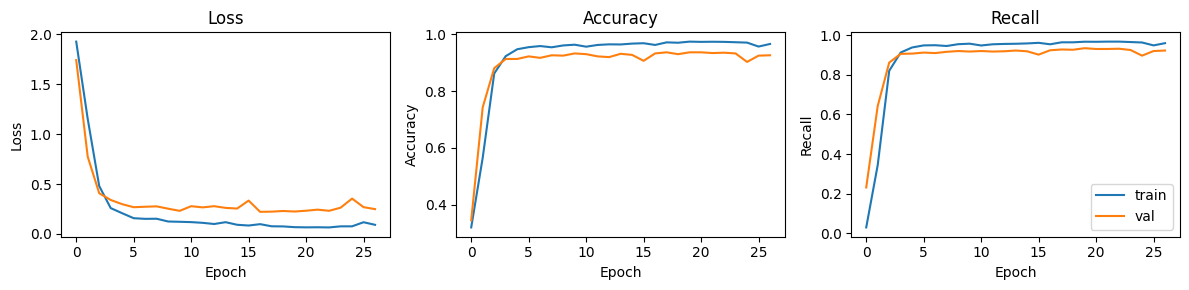

Loss (best epoch):     training: 0.0767     validation: 0.2234
Accuracy (best epoch): training: 0.9714     validation: 0.9364
Recall (best epoch):   training: 0.9649     validation: 0.9286
Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=3


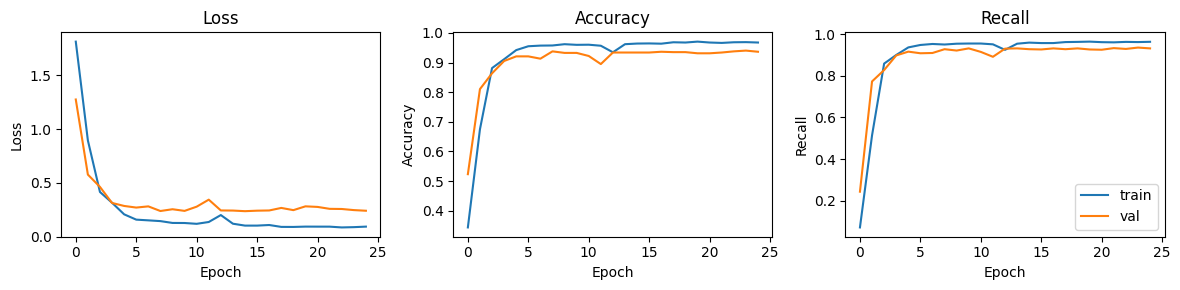

Loss (best epoch):     training: 0.1016     validation: 0.2405
Accuracy (best epoch): training: 0.9645     validation: 0.9338
Recall (best epoch):   training: 0.9567     validation: 0.9260
Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU=None, kernel_regularizer_Dense='l2', num_GRU_layers=2


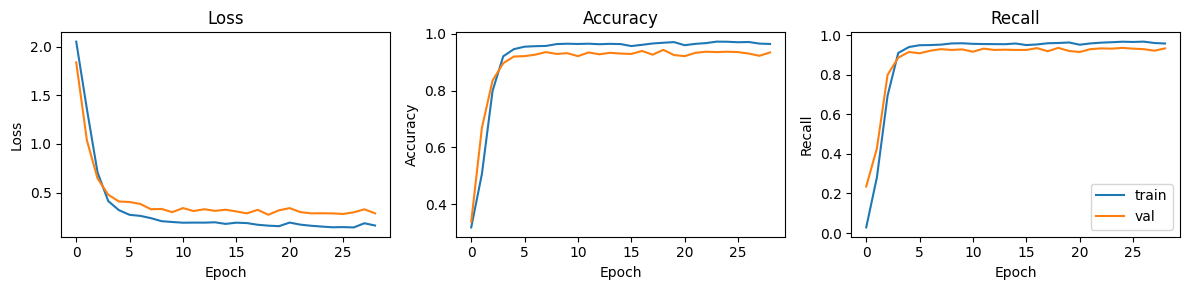

Loss (best epoch):     training: 0.1539     validation: 0.3173
Accuracy (best epoch): training: 0.9701     validation: 0.9247
Recall (best epoch):   training: 0.9623     validation: 0.9195
Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU=None, kernel_regularizer_Dense='l2', num_GRU_layers=3


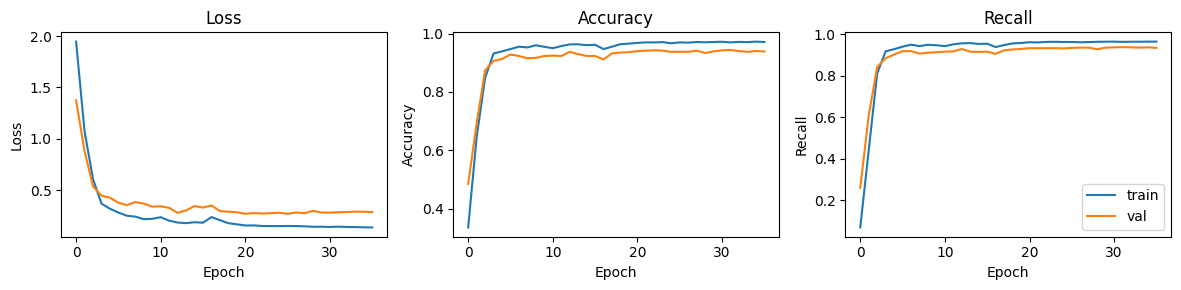

Loss (best epoch):     training: 0.1496     validation: 0.2825
Accuracy (best epoch): training: 0.9692     validation: 0.9377
Recall (best epoch):   training: 0.9623     validation: 0.9364
Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU='l2', kernel_regularizer_Dense=None, num_GRU_layers=2


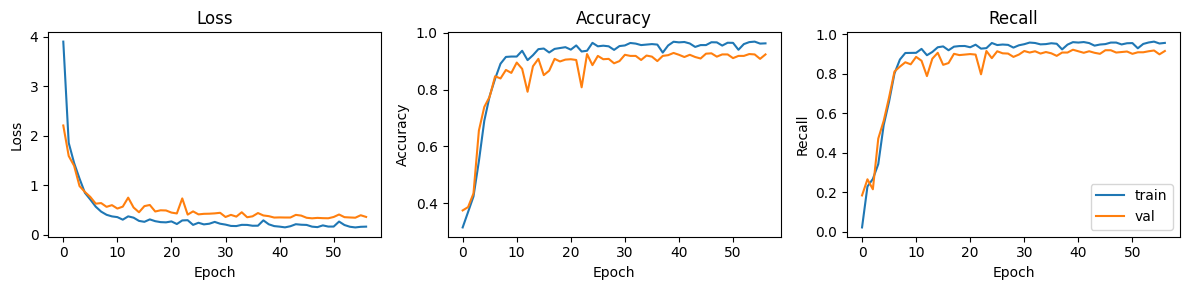

Loss (best epoch):     training: 0.1502     validation: 0.3367
Accuracy (best epoch): training: 0.9658     validation: 0.9156
Recall (best epoch):   training: 0.9584     validation: 0.9078
Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU='l2', kernel_regularizer_Dense=None, num_GRU_layers=3


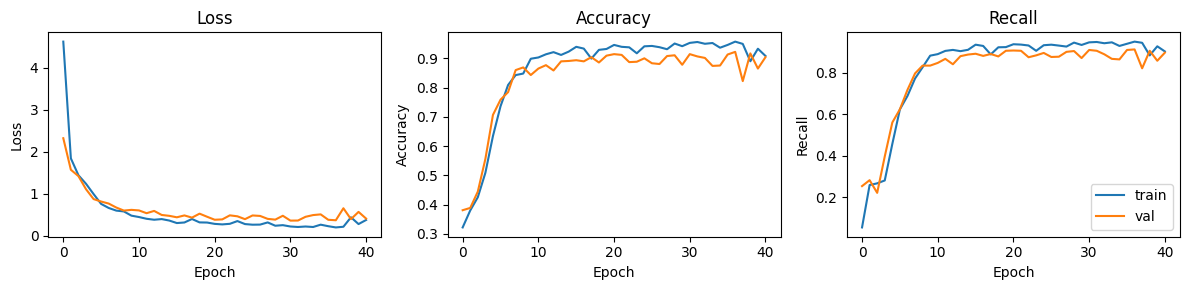

Loss (best epoch):     training: 0.2078     validation: 0.3615
Accuracy (best epoch): training: 0.9558     validation: 0.9065
Recall (best epoch):   training: 0.9476     validation: 0.9052
Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU='l2', kernel_regularizer_Dense='l2', num_GRU_layers=2


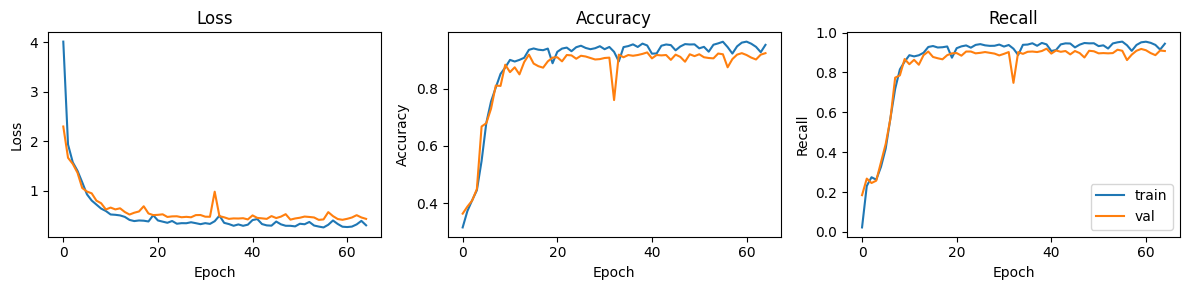

Loss (best epoch):     training: 0.2545     validation: 0.4166
Accuracy (best epoch): training: 0.9632     validation: 0.9195
Recall (best epoch):   training: 0.9549     validation: 0.9091
Parameters: embedding_dim=256, use_drop_out=False, kernel_regularizer_GRU='l2', kernel_regularizer_Dense='l2', num_GRU_layers=3


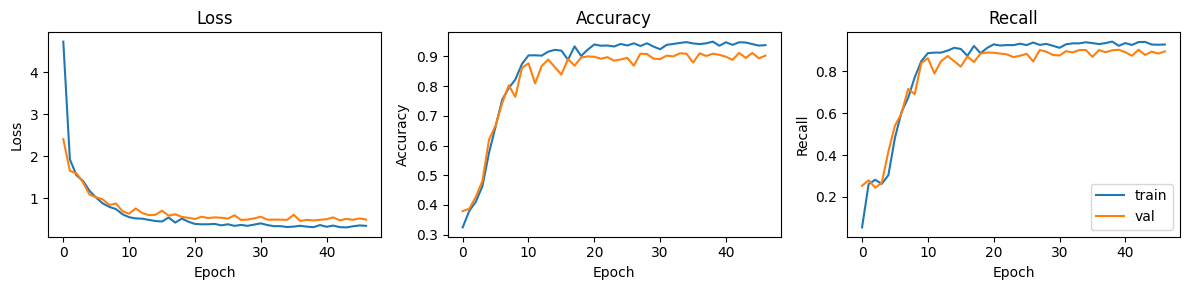

Loss (best epoch):     training: 0.3182     validation: 0.4802
Accuracy (best epoch): training: 0.9441     validation: 0.9013
Recall (best epoch):   training: 0.9345     validation: 0.8909
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=2


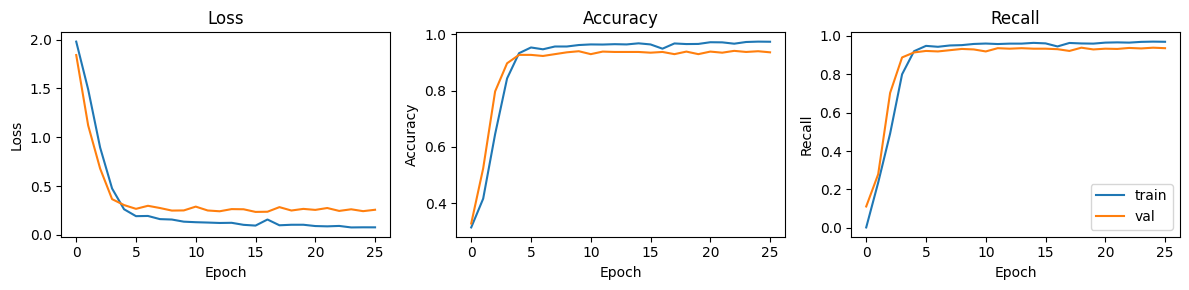

Loss (best epoch):     training: 0.1580     validation: 0.2376
Accuracy (best epoch): training: 0.9493     validation: 0.9377
Recall (best epoch):   training: 0.9441     validation: 0.9299
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=3


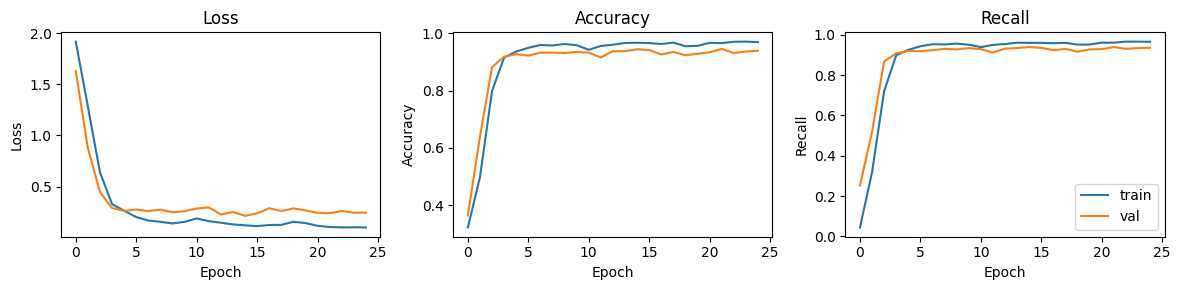

Loss (best epoch):     training: 0.1140     validation: 0.2385
Accuracy (best epoch): training: 0.9658     validation: 0.9416
Recall (best epoch):   training: 0.9597     validation: 0.9351
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense='l2', num_GRU_layers=2


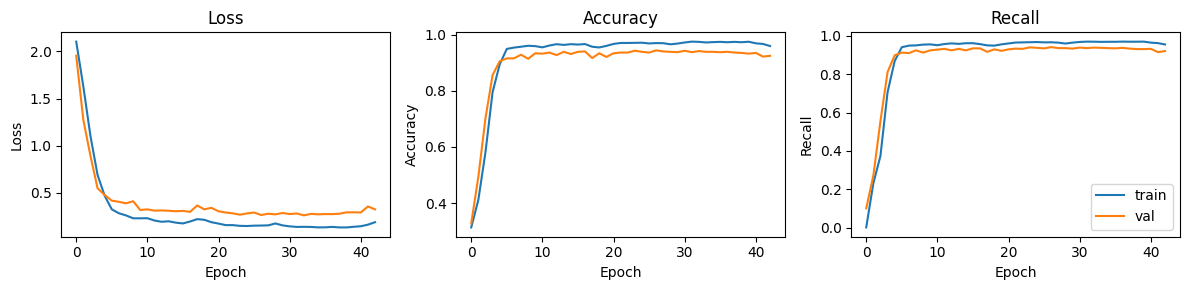

Loss (best epoch):     training: 0.1403     validation: 0.2786
Accuracy (best epoch): training: 0.9723     validation: 0.9390
Recall (best epoch):   training: 0.9675     validation: 0.9364
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense='l2', num_GRU_layers=3


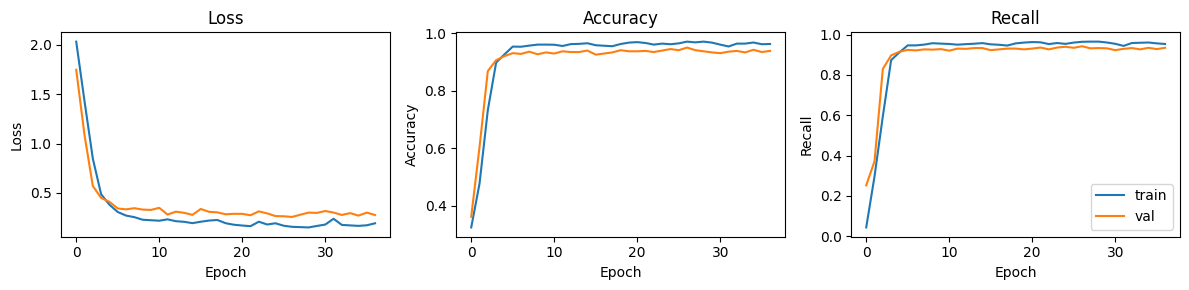

Loss (best epoch):     training: 0.1542     validation: 0.2801
Accuracy (best epoch): training: 0.9688     validation: 0.9416
Recall (best epoch):   training: 0.9658     validation: 0.9325
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU='l2', kernel_regularizer_Dense=None, num_GRU_layers=2


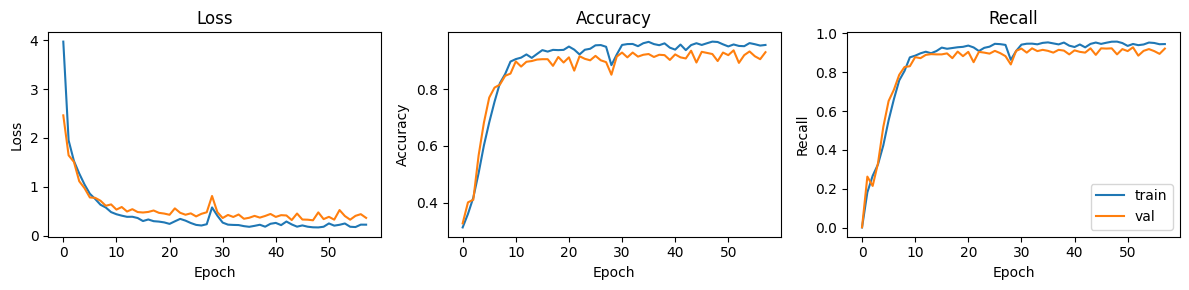

Loss (best epoch):     training: 0.1663     validation: 0.4743
Accuracy (best epoch): training: 0.9658     validation: 0.8987
Recall (best epoch):   training: 0.9580     validation: 0.8922
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU='l2', kernel_regularizer_Dense=None, num_GRU_layers=3


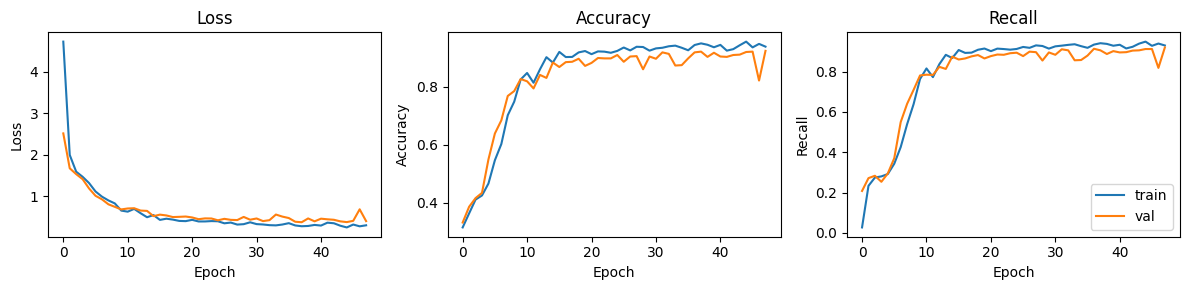

Loss (best epoch):     training: 0.2837     validation: 0.4649
Accuracy (best epoch): training: 0.9458     validation: 0.9039
Recall (best epoch):   training: 0.9371     validation: 0.8870
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU='l2', kernel_regularizer_Dense='l2', num_GRU_layers=2


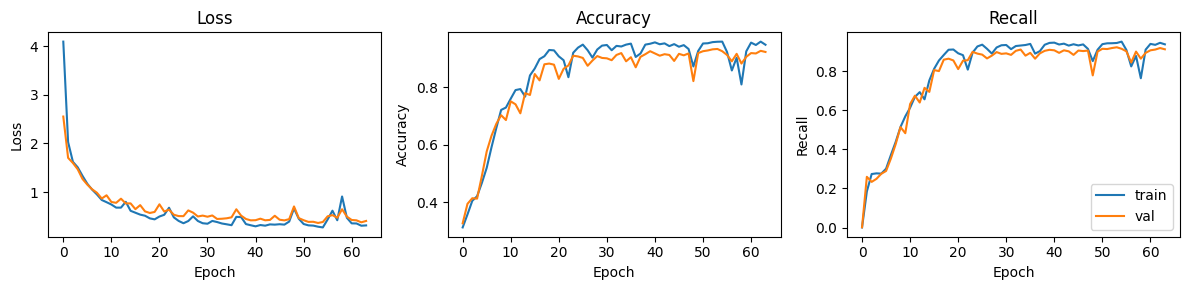

Loss (best epoch):     training: 0.2766     validation: 0.3881
Accuracy (best epoch): training: 0.9580     validation: 0.9247
Recall (best epoch):   training: 0.9523     validation: 0.9156
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU='l2', kernel_regularizer_Dense='l2', num_GRU_layers=3


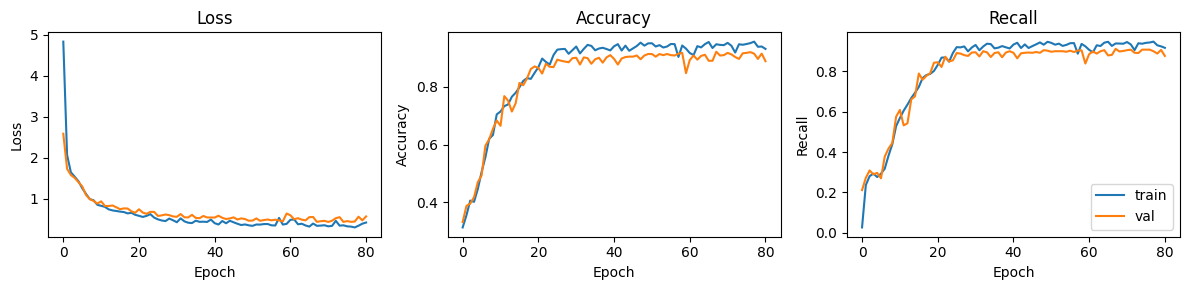

Loss (best epoch):     training: 0.3369     validation: 0.4622
Accuracy (best epoch): training: 0.9415     validation: 0.9117
Recall (best epoch):   training: 0.9337     validation: 0.9078


In [20]:
# hyperparameters to tune
embedding_dim = [256]
use_drop_out = [False, True]
kernel_regularizer_GRU = [None, 'l2']
kernel_regularizer_Dense = [None, 'l2']
num_GRU_layers = [2, 3]

epochs = 100
param_grid = itertools.product(embedding_dim, use_drop_out, kernel_regularizer_GRU, kernel_regularizer_Dense, num_GRU_layers) # all combinations of hyperparameters
results = []

for embedding_dim, use_drop_out, kernel_regularizer_GRU, kernel_regularizer_Dense, num_GRU_layers in param_grid:
  model = build_model(vocab_size=650, max_length=12, embedding_dim=embedding_dim, num_GRU_layers=num_GRU_layers, use_drop_out=use_drop_out, kernel_regularizer_GRU=kernel_regularizer_GRU, kernel_regularizer_Dense=kernel_regularizer_Dense)
  print(f'Parameters: {embedding_dim=}, {use_drop_out=}, {kernel_regularizer_GRU=}, {kernel_regularizer_Dense=}, {num_GRU_layers=}')
  train_loss, val_loss, train_accuracy, val_accuracy, train_recall, val_recall = train_validate_and_plot(model=model, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=epochs, batch_size=32, early_stopping=True)
  results.append({
      'embedding_dim': embedding_dim,
      'use_drop_out': use_drop_out,
      'kernel_regularizer_GRU': kernel_regularizer_GRU,
      'kernel_regularizer_Dense':kernel_regularizer_Dense,
      'num_GRU_layers':num_GRU_layers,
      'train_loss': train_loss,
      'val_loss': val_loss,
      'train_accuracy': train_accuracy,
      'val_accuracy': val_accuracy,
      'train_recall': train_recall,
      'val_recall': val_recall

  })
  print('=' * 50 + '\n', end='')

In [24]:
# visualize results from hyperparameter tuning 1
df_results = pd.DataFrame(results)
print("\nSummary Table:")
display(df_results)


Summary Table:


,embedding_dim,use_drop_out,kernel_regularizer_GRU,kernel_regularizer_Dense,num_GRU_layers,train_loss,val_loss,train_accuracy,val_accuracy,train_recall,val_recall
0,256,False,None,None,2,0.076657,0.223405,0.971391,0.936364,0.964889,0.928571
1,256,False,None,None,3,0.101630,0.240481,0.964456,0.933766,0.956654,0.925974
2,256,False,None,l2,2,0.153948,0.317295,0.970091,0.924675,0.962289,0.919481
3,256,False,None,l2,3,0.149573,0.282537,0.969224,0.937662,0.962289,0.936364
4,256,False,l2,None,2,0.150155,0.336686,0.965756,0.915584,0.958387,0.907792
5,256,False,l2,None,3,0.207772,0.361462,0.955787,0.906493,0.947551,0.905195
6,256,False,l2,l2,2,0.254458,0.416616,0.963156,0.919481,0.954920,0.909091
7,256,False,l2,l2,3,0.318207,0.480231,0.944083,0.901299,0.934547,0.890909
8,256,True,None,None,2,0.157975,0.237604,0.949285,0.937662,0.944083,0.929870
9,256,True,None,None,3,0.114009,0.238527,0.965756,0.941558,0.959688,0.935065


Best performance is with Dropout, no kernel_regulizer of GRU layers and with or without kernel_regulizer of Dense layer. Resulting architecutre is further tuned in next step.

## Hyperparameter tuning 2

Focus on embedding dimensions and number of GRU layers. Early stopping is implemented.

Parameters: embedding_dim=32, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=3


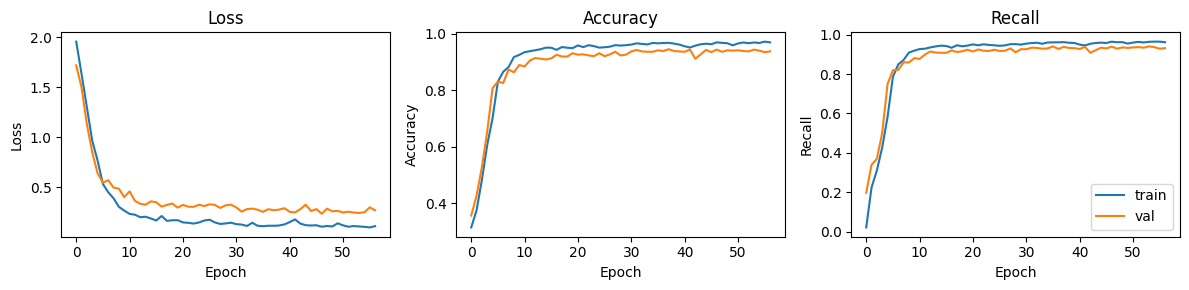

Best epoch: 56
Loss (best epoch):     training: 0.0953     validation: 0.2967
Accuracy (best epoch): training: 0.9723     validation: 0.9351
Recall (best epoch):   training: 0.9645     validation: 0.9286
Parameters: embedding_dim=32, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=4


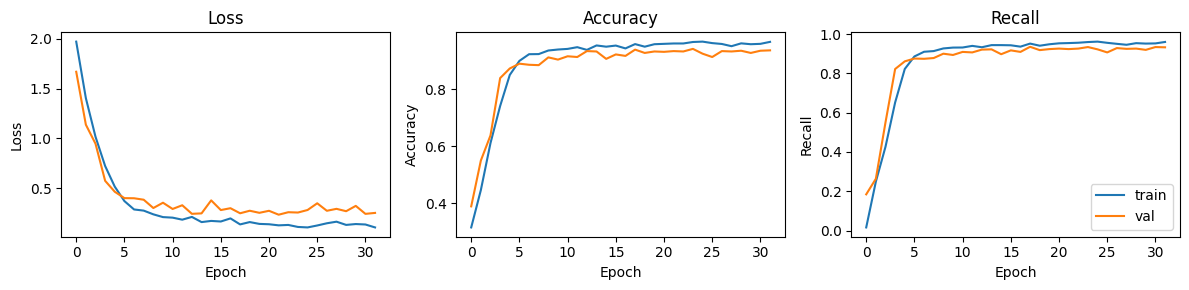

Best epoch: 26
Loss (best epoch):     training: 0.1296     validation: 0.3517
Accuracy (best epoch): training: 0.9619     validation: 0.9130
Recall (best epoch):   training: 0.9554     validation: 0.9065
Parameters: embedding_dim=32, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=5


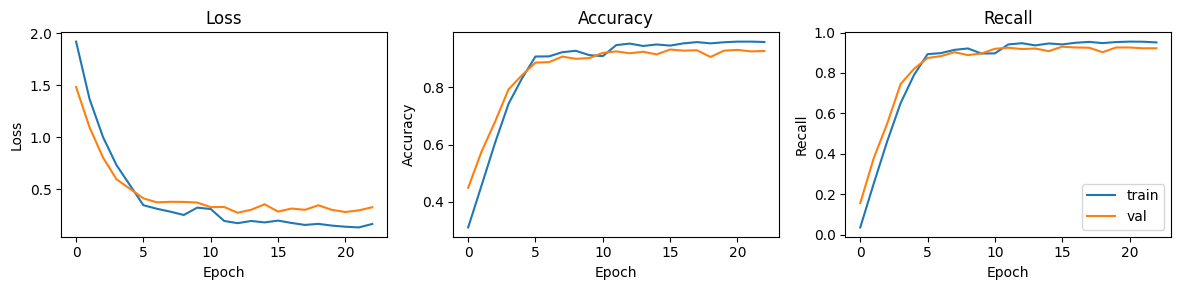

Best epoch: 15
Loss (best epoch):     training: 0.1786     validation: 0.3535
Accuracy (best epoch): training: 0.9502     validation: 0.9156
Recall (best epoch):   training: 0.9458     validation: 0.9078
Parameters: embedding_dim=64, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=3


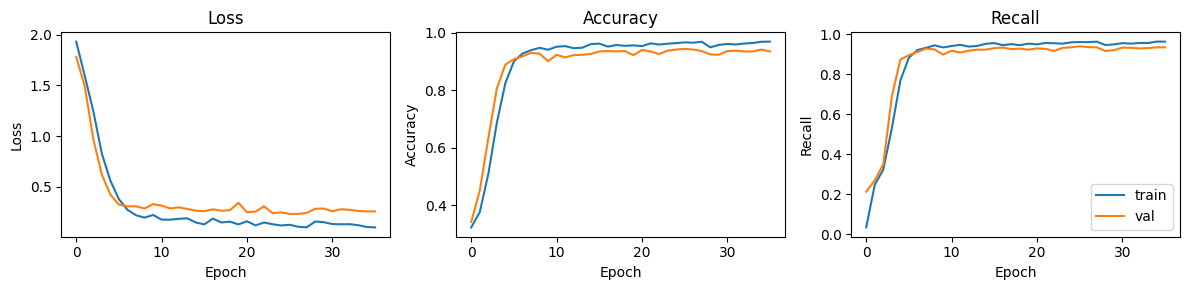

Best epoch: 30
Loss (best epoch):     training: 0.1509     validation: 0.2856
Accuracy (best epoch): training: 0.9580     validation: 0.9234
Recall (best epoch):   training: 0.9484     validation: 0.9195
Parameters: embedding_dim=64, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=4


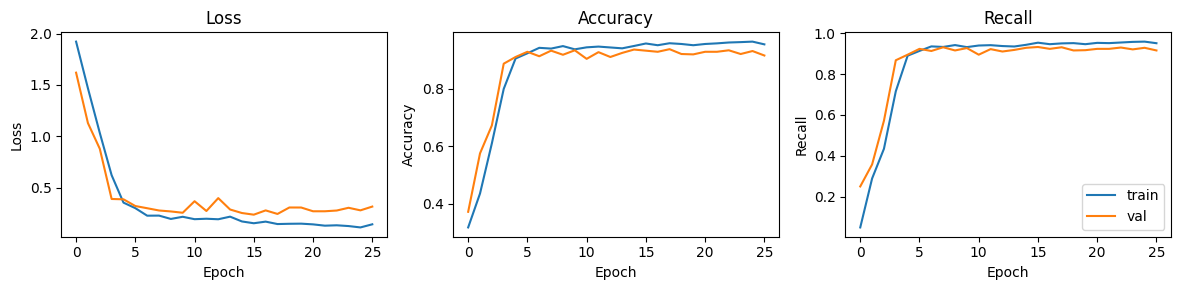

Best epoch: 26
Loss (best epoch):     training: 0.1430     validation: 0.3156
Accuracy (best epoch): training: 0.9558     validation: 0.9169
Recall (best epoch):   training: 0.9510     validation: 0.9156
Parameters: embedding_dim=64, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=5


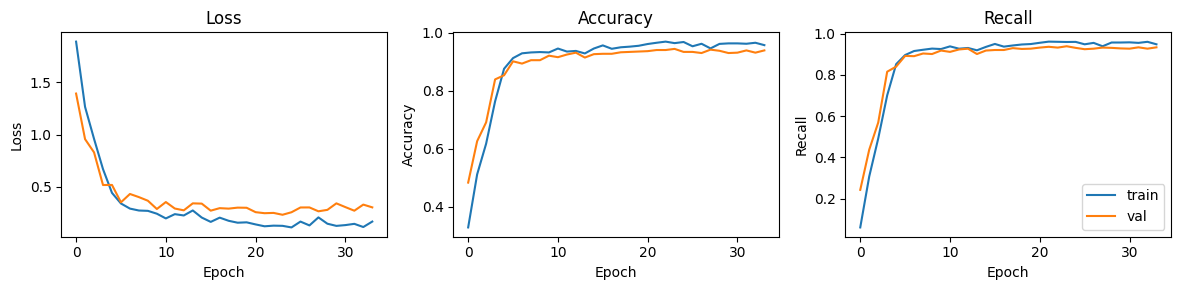

Best epoch: 30
Loss (best epoch):     training: 0.1248     validation: 0.3405
Accuracy (best epoch): training: 0.9632     validation: 0.9299
Recall (best epoch):   training: 0.9571     validation: 0.9286
Parameters: embedding_dim=128, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=3


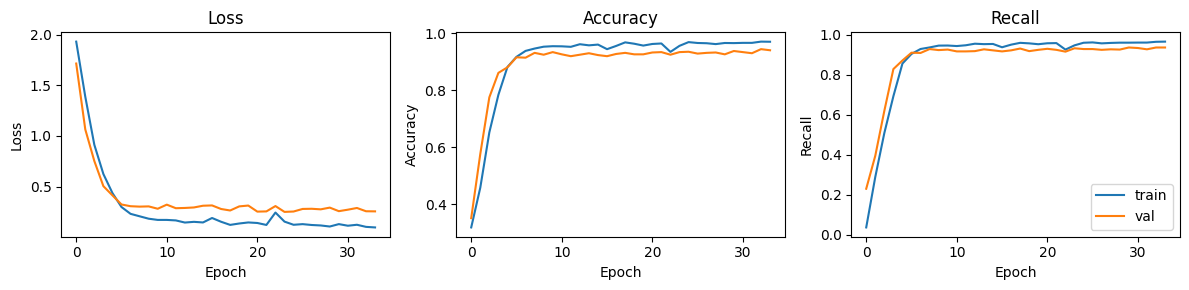

Best epoch: 29
Loss (best epoch):     training: 0.1053     validation: 0.2921
Accuracy (best epoch): training: 0.9658     validation: 0.9260
Recall (best epoch):   training: 0.9606     validation: 0.9260
Parameters: embedding_dim=128, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=4


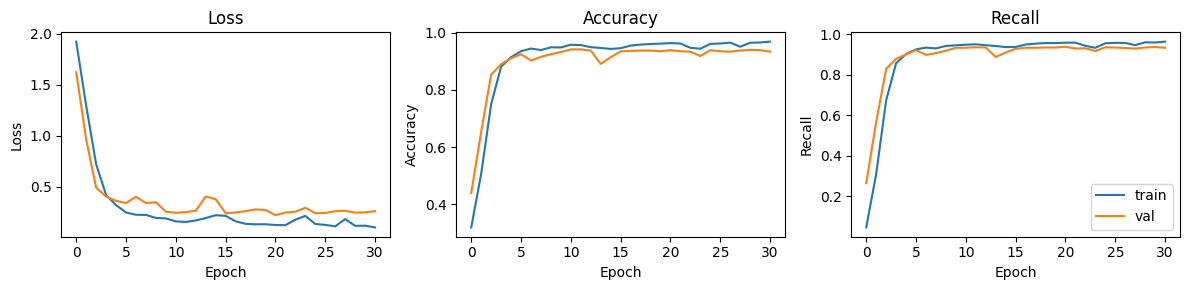

Best epoch: 24
Loss (best epoch):     training: 0.2161     validation: 0.2953
Accuracy (best epoch): training: 0.9441     validation: 0.9182
Recall (best epoch):   training: 0.9324     validation: 0.9169
Parameters: embedding_dim=128, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=5


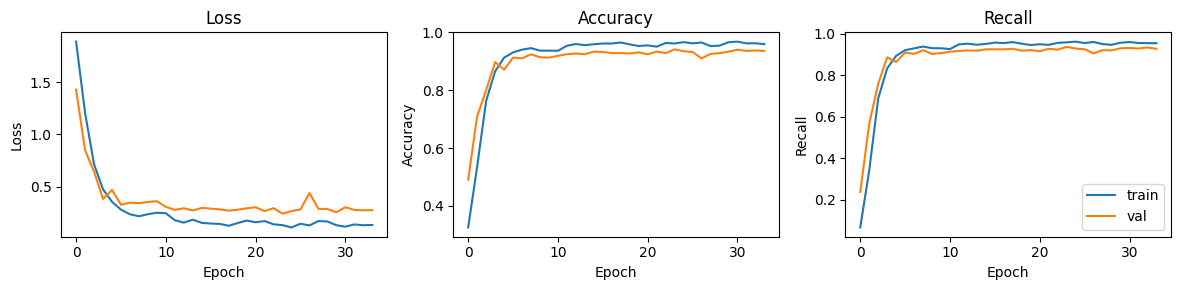

Best epoch: 27
Loss (best epoch):     training: 0.1265     validation: 0.4382
Accuracy (best epoch): training: 0.9653     validation: 0.9104
Recall (best epoch):   training: 0.9614     validation: 0.9065
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=3


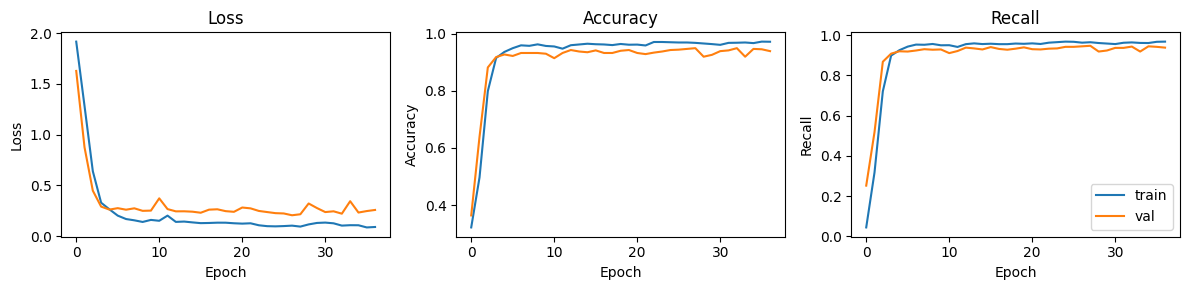

Best epoch: 34
Loss (best epoch):     training: 0.1081     validation: 0.3443
Accuracy (best epoch): training: 0.9692     validation: 0.9195
Recall (best epoch):   training: 0.9610     validation: 0.9182
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=4


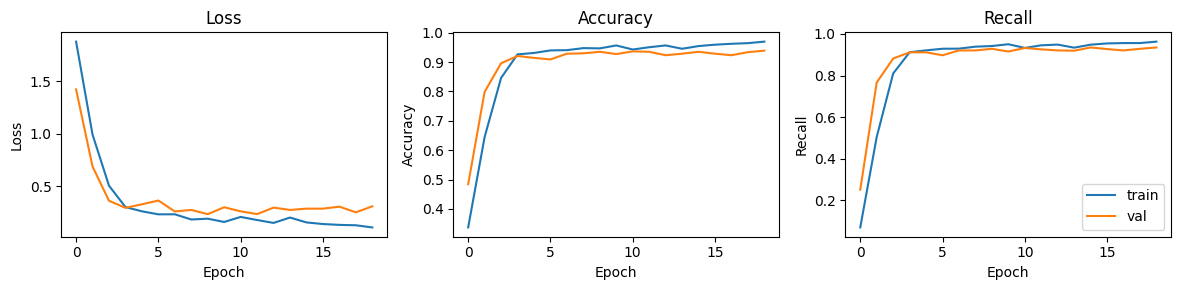

Best epoch: 19
Loss (best epoch):     training: 0.1064     validation: 0.3078
Accuracy (best epoch): training: 0.9697     validation: 0.9390
Recall (best epoch):   training: 0.9632     validation: 0.9351
Parameters: embedding_dim=256, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=5


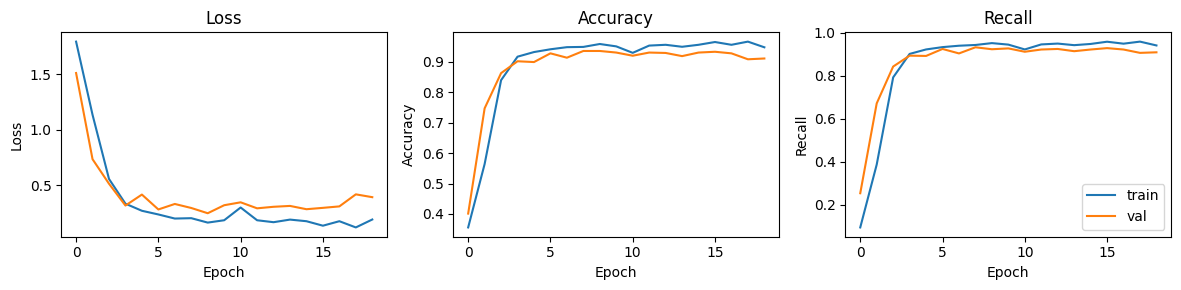

Best epoch: 18
Loss (best epoch):     training: 0.1208     validation: 0.4189
Accuracy (best epoch): training: 0.9658     validation: 0.9078
Recall (best epoch):   training: 0.9588     validation: 0.9065
Parameters: embedding_dim=512, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=3


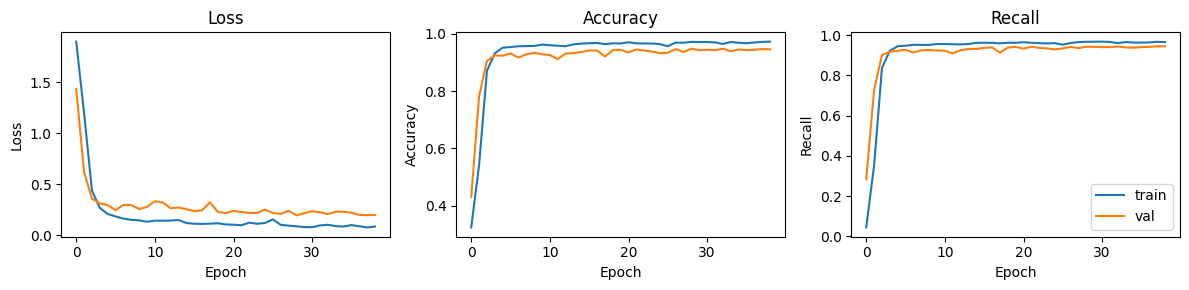

Best epoch: 31
Loss (best epoch):     training: 0.0777     validation: 0.2350
Accuracy (best epoch): training: 0.9714     validation: 0.9442
Recall (best epoch):   training: 0.9675     validation: 0.9403
Parameters: embedding_dim=512, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=4


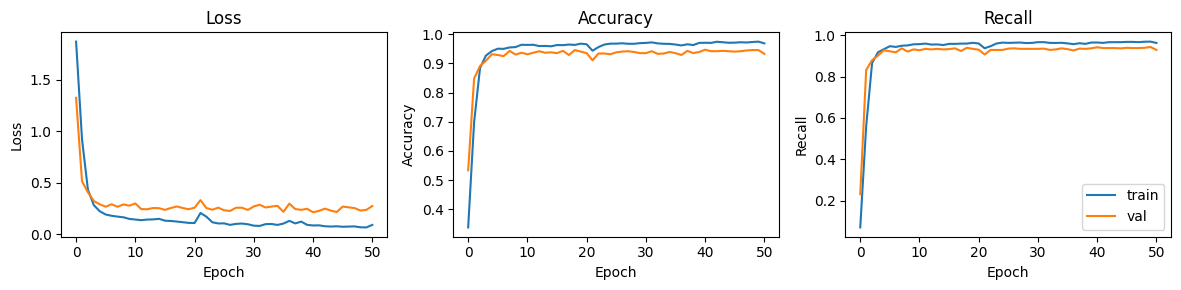

Best epoch: 51
Loss (best epoch):     training: 0.0892     validation: 0.2723
Accuracy (best epoch): training: 0.9684     validation: 0.9325
Recall (best epoch):   training: 0.9623     validation: 0.9286
Parameters: embedding_dim=512, use_drop_out=True, kernel_regularizer_GRU=None, kernel_regularizer_Dense=None, num_GRU_layers=5


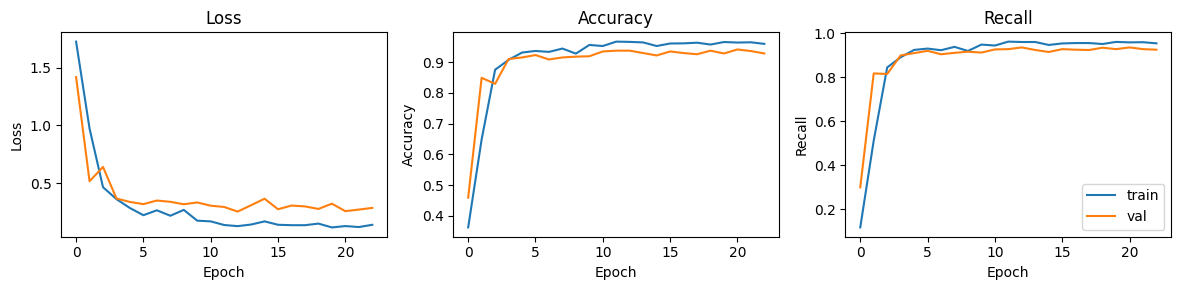

Best epoch: 15
Loss (best epoch):     training: 0.1707     validation: 0.3663
Accuracy (best epoch): training: 0.9528     validation: 0.9221
Recall (best epoch):   training: 0.9476     validation: 0.9156


In [51]:
# hyperparameters to tune
embedding_dim = [32, 64, 128, 256, 512]
use_drop_out = [True]
kernel_regularizer_GRU = [None]
kernel_regularizer_Dense = [None]
num_GRU_layers = [3, 4, 5]

epochs = 100
param_grid = itertools.product(embedding_dim, use_drop_out, kernel_regularizer_GRU, kernel_regularizer_Dense, num_GRU_layers) # all combinations of hyperparameters
results = []

for embedding_dim, use_drop_out, kernel_regularizer_GRU, kernel_regularizer_Dense, num_GRU_layers in param_grid:
  model = build_model(vocab_size=650, max_length=12, embedding_dim=embedding_dim, num_GRU_layers=num_GRU_layers, use_drop_out=use_drop_out, kernel_regularizer_GRU=kernel_regularizer_GRU, kernel_regularizer_Dense=kernel_regularizer_Dense)
  print(f'Parameters: {embedding_dim=}, {use_drop_out=}, {kernel_regularizer_GRU=}, {kernel_regularizer_Dense=}, {num_GRU_layers=}')
  train_loss, val_loss, train_accuracy, val_accuracy, train_recall, val_recall = train_validate_and_plot(model=model, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=epochs, batch_size=32, early_stopping=True)
  results.append({
      'embedding_dim': embedding_dim,
      'use_drop_out': use_drop_out,
      'kernel_regularizer_GRU': kernel_regularizer_GRU,
      'kernel_regularizer_Dense':kernel_regularizer_Dense,
      'num_GRU_layers':num_GRU_layers,
      'train_loss': train_loss,
      'val_loss': val_loss,
      'train_accuracy': train_accuracy,
      'val_accuracy': val_accuracy,
      'train_recall': train_recall,
      'val_recall': val_recall

  })
  print('=' * 50 + '\n', end='')

In [52]:
# visualize results from hyperparameter tuning 2
df_results = pd.DataFrame(results)
print("\nSummary Table:")
display(df_results)


Summary Table:


,embedding_dim,use_drop_out,kernel_regularizer_GRU,kernel_regularizer_Dense,num_GRU_layers,train_loss,val_loss,train_accuracy,val_accuracy,train_recall,val_recall
0,32,True,None,None,3,0.095322,0.296698,0.972258,0.935065,0.964456,0.928571
1,32,True,None,None,4,0.129563,0.351653,0.961855,0.912987,0.955353,0.906493
2,32,True,None,None,5,0.178609,0.353496,0.950152,0.915584,0.945817,0.907792
3,64,True,None,None,3,0.150867,0.285564,0.957954,0.923377,0.948418,0.919481
4,64,True,None,None,4,0.142996,0.315576,0.955787,0.916883,0.951019,0.915584
5,64,True,None,None,5,0.124783,0.340481,0.963156,0.929870,0.957087,0.928571
6,128,True,None,None,3,0.105301,0.292060,0.965756,0.925974,0.960555,0.925974
7,128,True,None,None,4,0.216140,0.295327,0.944083,0.918182,0.932380,0.916883
8,128,True,None,None,5,0.126536,0.438220,0.965323,0.910390,0.961422,0.906493
9,256,True,None,None,3,0.108121,0.344337,0.969224,0.919481,0.960988,0.918182


Best results for embedding dimension 512 and 3 GRU layers.

In [27]:
# df_results.to_csv('/content/drive/MyDrive/Colab Notebooks/project_hate_retoric/data/results_embedding_dims.csv')
# df_results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_hate_retoric/data/results_embedding_dims.csv', index_col=0)

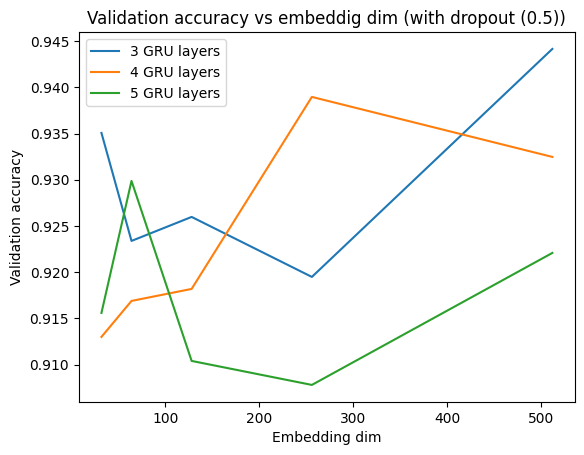

In [39]:
# display validation accuracy as function of embeddings dimensions for 3, 4 and 5 GRU layers.
df_3 = df_results[df_results['num_GRU_layers'] == 3]
df_4 = df_results[df_results['num_GRU_layers'] == 4]
df_5 = df_results[df_results['num_GRU_layers'] == 5]

plt.plot(df_3['embedding_dim'], df_3['val_accuracy'], label='3 GRU layers')
plt.plot(df_4['embedding_dim'], df_4['val_accuracy'], label='4 GRU layers')
plt.plot(df_5['embedding_dim'], df_5['val_accuracy'], label='5 GRU layers')
plt.xlabel('Embedding dim')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs embeddig dim (with dropout (0.5))')
plt.legend();

In conclusion, high embeddings dimension is the largest factor affecting convergence and outcome. Other hyperparameters have a small influence however the magnitude of change is small.

# 6. Train best model

In [18]:
# compile the best model
set_random_seed(42)
embedding_dim = 512

model_best = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_best.compile(
  optimizer=tf.keras.optimizers.AdamW(weight_decay=0.004),
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 512)           332800    
                                                                 
 gru (GRU)                   (None, 12, 128)           246528    
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 12, 128)           99072     
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

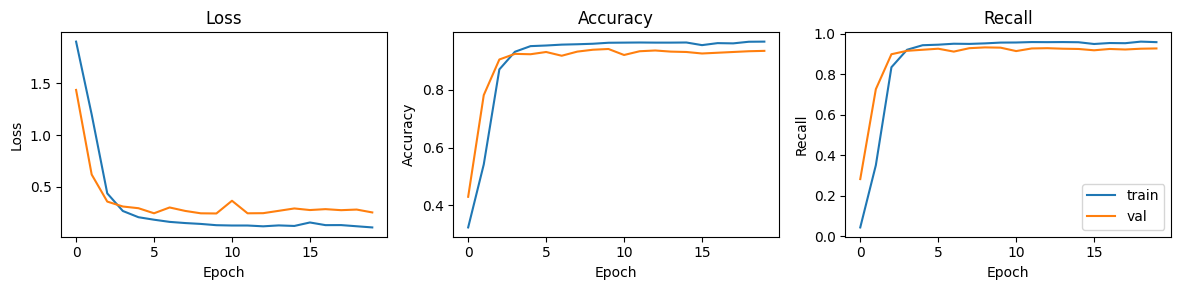

Best epoch: 11
Loss (best epoch):     training: 0.1277     validation: 0.3665
Accuracy (best epoch): training: 0.9636     validation: 0.9208
Recall (best epoch):   training: 0.9580     validation: 0.9156


(0.12766295671463013,
 0.3664800524711609,
 0.963589072227478,
 0.9207792282104492,
 0.9579540491104126,
 0.9155844449996948)

In [19]:
train_validate_and_plot(model=model_best, X_train=X_train_tokenized, y_train=y_train, X_val=X_val_tokenized, y_val=y_val, epochs=100, batch_size=32, early_stopping=True)

In [20]:
# evaluate model on test data
test_model(model_best, X_test_tokenized, y_test)

Test loss: 0.2202
Test accuracy: 0.9338
Test recall: 0.9312


Number of false negatives: 10 (1.30%)


Classification report:
                                 precision    recall  f1-score   support

                    non-hateful       0.96      0.94      0.95       242
          hateful against women       0.76      0.94      0.84        69
   hateful against trans people       0.96      0.93      0.94        72
     hateful against gay people       0.96      0.90      0.93        79
   hateful against black people       0.99      0.97      0.98        76
hateful against disabled people       0.97      0.94      0.96        83
        hateful against Muslims       0.91      0.93      0.92        73
     hateful against immigrants       0.95      0.91      0.93        76

                       accuracy                           0.93       770
                      macro avg       0.93      0.93      0.93       770
                   weighted avg       0.94      0.93      0.93       770

Confusion matrix:


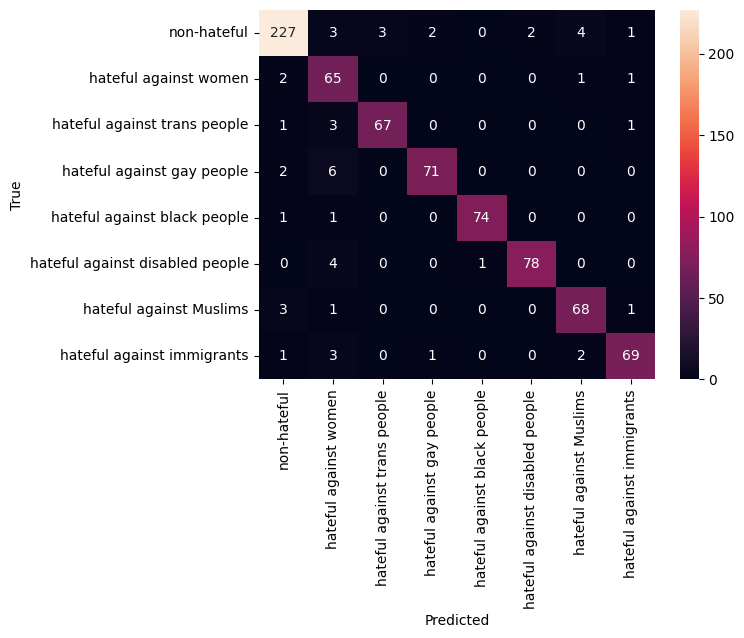


Missclassified test samples:


,test_case_cleaned,true_label,predicted_label
20,im go help muslim tomorrow,non-hateful,hateful against Muslims
36,nothing m0ng,hateful against disabled people,hateful against women
38,typical tr4nny behaviour,hateful against trans people,hateful against women
70,go make disable people smile,non-hateful,hateful against disabled people
99,many h e l e country,hateful against trans people,hateful against women
126,nothing j1hadi,hateful against Muslims,hateful against women
137,seriously consider strangle judge,non-hateful,hateful against women
155,cut transthroats,hateful against trans people,non-hateful
164,cannot believe thisshemale,hateful against trans people,hateful against immigrants
173,go make trans people smile,non-hateful,hateful against trans people



51 samples were missclassified in test data


In [21]:
# display metrics on test data
display_test_metrics(model_best, X_test_tokenized, X_test, y_test, labels_dict, display_classification_report=True, display_confusion_matrix=True, display_missclassified=True)

The best model resulst in 93% accuracy and recall on test data. Missclassified samples often contain miss-spelled words.
Results show again that 'hateful against women' is the most difficult category, where (as seen by precision/recall/f1 and in confusion matrix) other categories are missclassified as 'hateful against women' (false positives are over-represented).

# 7. Conclusions

Fairly simple GRU network could be used to detect and classify hate retoric with 93% accuracy.\
\
There seem to be a random component in training considering varying results from for example: best model in hyperparametertuning 2 (section 5) and best model (section 6). It is important to note that the hyperparameter tuning results generally in very small performance changes. In addition, early stopping was not used in hyperparametertuning 1 (section 4) where results were compared after 30 epochs instad of at the best epoch, which might be missleading.\
\
Additional tests could be done with varying batchsizes, keeping stop words and ballancing classes in train data. Further improvement could perhaps also be atcheved with precalculated word or sentence embeddings prior to modeling as in  https://www.kaggle.com/code/sepidafs/text-classification-with-glove-lstm-gru-99-acc if transfer learning was permitted in the project.\
\
In the current project 8 labels were created and information about target group for non-hateful samples has been dicarded. Another solution could have been to define two separate models specified in classification of:
* hateful/non-hateful
* one of the 7 target groups